In [ ]:
# Original code from Ozan Tokatli and Jason Moore in pantograph.py  

In [21]:
# Import SymPy mechanics modules
from sympy import symbols, solve
from sympy.physics.mechanics import *

Vector.simp = False # To increase the computation speed

# Define the configuration variables and their derivatives
q1, q2, q3, q4 = dynamicsymbols('q1 q2 q3 q4')
q1d, q2d, q3d, q4d = dynamicsymbols('q1 q2 q3 q4', 1)
#q = dynamicsymbols('q:'+str(5))     # I won't be using the first element q0(t)

# Define the generalized speeds
#u = dynamicsymbols('u:'+str(5))
u1, u2, u3, u4 = dynamicsymbols('u1 u2 u3 u4')
u1d, u2d, u3d, u4d = dynamicsymbols('u1 u2 u3 u4', 1)

# Define the link lengths
l0, l1, l2, l3, l4 = symbols('l0 l1 l2 l3 l4')
#l = symbols('l:'+str(5))

# Define the masses
mA, mB, mC, mD = symbols('mA mB mC mD')

# Define external forces
Fx, Fy = symbols('Fx Fy')

# Define the gravitational constant and the time
g, t = symbols('g t')

# Define the Newtonian reference frame
N = ReferenceFrame('N')

# Define the orientation of the frames with respect to the Newtonian frame
A = N.orientnew('A', 'Body', [0, 0, q1], '123')
B = N.orientnew('B', 'Body', [0, 0, q2], '123')
C = N.orientnew('C', 'Body', [0, 0, q3], '123')
D = N.orientnew('D', 'Body', [0, 0, q4], '123')

# Set angular velocities of frames with the u's
A.set_ang_vel(N, u1 * N.z)
B.set_ang_vel(N, u2 * N.z)
C.set_ang_vel(N, u3 * N.z)
D.set_ang_vel(N, u4 * N.z)

# Define the points
O1 = Point('O1')
P = O1.locatenew('P', l1*A.x)
Q = P.locatenew('Q', l2*B.x)
R = Q.locatenew('R', -l3*C.x)
O2 = R.locatenew('O2', -l4*D.x)

Ao = O1.locatenew('Ao', l1/2*A.x)
Bo = P.locatenew('Bo', l2/2*B.x)
Co = R.locatenew('Co', l3/2*C.x)
Do = O2.locatenew('Do', l4/2*D.x)

# Set the velocity of the fixed points
O1.set_vel(N, 0)
O2.set_vel(N, 0)

# Define the unconstrained velocities of the points
P.v2pt_theory(O1, N, A)
Q.v2pt_theory(P, N, B)
R.v2pt_theory(Q, N, C)

Ao.v2pt_theory(O1, N, A)
Bo.v2pt_theory(P, N, B)
Co.v2pt_theory(Q, N, C)
Do.v2pt_theory(R, N, D)

# Define the kinematic differential equations
kd = [q1d-u1, q2d-u2, q3d-u3, q4d-u4]

# Define the configuration level constraints
zero = O2.pos_from(O1) + l0 * N.x
conlist_coor = [zero & N.x, zero & N.y]

# Define the velocity level constraints
dzero = time_derivative(zero, N)
conlist_speed = [dzero & N.x, dzero & N.y]

# Define the inertia dyads
IA11, IA22, IA33, IA12, IA23, IA31 = symbols('IA11 IA22 IA33 IA12 IA23 IA31')
IB11, IB22, IB33, IB12, IB23, IB31 = symbols('IB11 IB22 IB33 IB12 IB23 IB31')
IC11, IC22, IC33, IC12, IC23, IC31 = symbols('IC11 IC22 IC33 IC12 IC23 IC31')
ID11, ID22, ID33, ID12, ID23, ID31 = symbols('ID11 ID22 ID33 ID12 ID23 ID31')
inertiaA = (inertia(A, IA11, IA22, IA33, IA12, IA23, IA31), Ao)
inertiaB = (inertia(B, IB11, IB22, IB33, IB12, IB23, IB31), Bo)
inertiaC = (inertia(C, IC11, IC22, IC33, IC12, IC23, IC31), Co)
inertiaD = (inertia(D, ID11, ID22, ID33, ID12, ID23, ID31), Do)

# Define the bodies
bodyA = RigidBody('bodyA', Ao, A, mA, inertiaA)
bodyB = RigidBody('bodyB', Bo, B, mB, inertiaB)
bodyC = RigidBody('bodyC', Co, C, mC, inertiaC)
bodyD = RigidBody('bodyD', Do, D, mD, inertiaD)

# Define the force list
FL = [(Ao, -mA*g*N.y), (Bo, -mB*g*N.y), (Co, -mC*g*N.y), (Do, -mD*g*N.y), (Q, Fx*N.x+Fy*N.y)]

# Define the body list
BL = [bodyA, bodyB, bodyC, bodyD]

# Use Kane's method to solve for the Equations on Motion of the system
KM = KanesMethod(N,
                 q_ind=[q1, q4],
                 u_ind=[u1, u4],
                 kd_eqs=kd,
                 q_dependent=[q2, q3],
                 configuration_constraints=conlist_coor,
                 u_dependent=[u2, u3],
                 velocity_constraints=conlist_speed)

(fr, frstar) = KM.kanes_equations(FL, BL)
kanezero = fr + frstar


# Code added for visualization by Octavio Narváez-Aroche

In [22]:
# Import functions for numerical arrays
from numpy import deg2rad, rad2deg, array, zeros, linspace

# Import numerical integration routine and ODE function generator.
from scipy.integrate import odeint
from pydy.codegen.ode_function_generators import generate_ode_function

# Import functions for plotting and set default figure size.  
from matplotlib.pyplot import plot, legend, xlabel, ylabel, rcParams
rcParams['figure.figsize'] = (14.0, 6.0)

# Import shapes for visualization 
from pydy.viz.shapes import Cylinder, Sphere
import pydy.viz
pydy.viz.shapes.__all__

# Import visualization methods
from pydy.viz.visualization_frame import VisualizationFrame
from pydy.viz.scene import Scene

# Define variables

# Constants
constants = [l0, 
             l1, 
             l2, 
             l3, 
             l4,
             mA,
             mB,
             mC,
             mD, 
             IA11, 
             IA22, 
             IA33, 
             IA12, 
             IA23, 
             IA31,
             IB11, 
             IB22, 
             IB33, 
             IB12, 
             IB23, 
             IB31,
             IC11, 
             IC22, 
             IC33, 
             IC12, 
             IC23, 
             IC31, 
             ID11, 
             ID22, 
             ID33, 
             ID12, 
             ID23, 
             ID31, 
             g]

# Time Varying 
coordinates = [q1, q2, q3, q4]
speeds = [u1, u2, u3, u4]

# Input Forces
specified = [Fx, Fy]

# Generate ODE Function
kdd = KM.kindiffdict()
mass_matrix = KM.mass_matrix_full.subs(kdd)
forcing_vector = KM.forcing_full.subs(kdd)

right_hand_side = generate_ode_function(forcing_vector, coordinates,
                                        speeds, constants,
                                        mass_matrix=mass_matrix,
                                        specifieds=specified)

# Set initial conditions, parameter values and time array 
x0 = zeros(8)

x0[0] = deg2rad(48) 
x0[1] = deg2rad(154)
x0[2] = deg2rad(33)
x0[3] = deg2rad(124)

numerical_constants = array([7.0, # l0 [m] 
                             3.0, # l1  [m]
                             7.0, # l2 [m]
                             5.0,  # l3 [m]
                             3.0,  # l4 [m]
                             1.0,   # mA [kg] 
                             1.0,   # mB [kg] 
                             1.0,   # mC [kg] 
                             1.0,   # mD [kg] 
                             1.0,   # IA11 [kg.m^2] 
                             1.0,   # IA22 [kg.m^2] 
                             1.0,   # IA33 [kg.m^2] 
                             1.0,   # IA12 [kg.m^2] 
                             1.0,   # IA23 [kg.m^2] 
                             1.0,   # IA31 [kg.m^2] 
                             1.0,   # IB11 [kg.m^2] 
                             1.0,   # IB22 [kg.m^2] 
                             1.0,   # IB33 [kg.m^2] 
                             1.0,   # IB12 [kg.m^2] 
                             1.0,   # IB23 [kg.m^2] 
                             1.0,   # IB31 [kg.m^2]
                             1.0,   # IC11 [kg.m^2] 
                             1.0,   # IC22 [kg.m^2] 
                             1.0,   # IC33 [kg.m^2] 
                             1.0,   # IC12 [kg.m^2] 
                             1.0,   # IC23 [kg.m^2] 
                             1.0,   # IC31 [kg.m^2]
                             1.0,   # ID11 [kg.m^2] 
                             1.0,   # ID22 [kg.m^2] 
                             1.0,   # ID33 [kg.m^2] 
                             1.0,   # ID12 [kg.m^2] 
                             1.0,   # ID23 [kg.m^2] 
                             1.0,   # ID31 [kg.m^2]
                             9.81], # acceleration due to gravity [m/s^2]
                            ) 

numerical_specified = zeros(2)

args = {'constants': numerical_constants,
        'specified': numerical_specified}

frames_per_sec = 1000
final_time = 1

t = linspace(0.0, final_time, final_time * frames_per_sec)

right_hand_side(x0, 0.0, numerical_specified, numerical_constants)

array([ 0.        ,  0.        ,  0.        ,  0.        , -2.30165594,
        2.28983323,  1.4425573 , -2.35012019])

# Integrate Equations of Motion

In [23]:
y = odeint(right_hand_side, x0, t, args=(numerical_specified, numerical_constants))

# Plot Angles

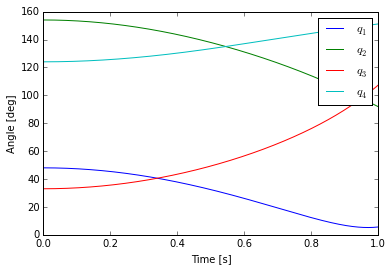

In [24]:
%matplotlib inline
plot(t, rad2deg(y[:, :4]))
xlabel('Time [s]')
ylabel('Angle [deg]')
legend(["${}$".format(vlatex(c)) for c in coordinates])

# Plot Angular Velocities

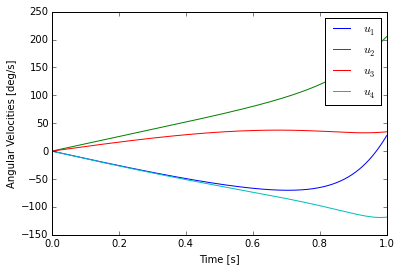

In [25]:
plot(t, rad2deg(y[:, 4:]))
xlabel('Time [s]')
ylabel('Angular Velocities [deg/s]')
legend(["${}$".format(vlatex(s)) for s in speeds])

# Visualization 

In [34]:
# Spheres to represent joints
O1_shape = Sphere(color='black', radius=0.08)
P_shape = Sphere(color='black', radius=0.08)
Q_shape = Sphere(color='black', radius=0.08)
R_shape = Sphere(color='black', radius=0.08)
O2_shape = Sphere(color='black', radius=0.08)

# Visualization frames
O1_viz_frame = VisualizationFrame(N, O1, O1_shape)
P_viz_frame = VisualizationFrame(N, P, P_shape)
Q_viz_frame = VisualizationFrame(N, Q, Q_shape)
R_viz_frame = VisualizationFrame(N, R, R_shape)
O2_viz_frame = VisualizationFrame(N, O2, O2_shape)

# Dictionary with numerical constants
constants_dict = dict(zip(constants, numerical_constants))

# Define additional frames for drawing the cylinders 
# Define the orientation of the frames with respect to the Newtonian frame
Ac = N.orientnew('A', 'Body', [0, 0, q1-3.1416/2], '123')
Bc = N.orientnew('B', 'Body', [0, 0, q2-3.1416/2], '123')
Cc = N.orientnew('C', 'Body', [0, 0, q3-3.1416/2], '123')
Dc = N.orientnew('D', 'Body', [0, 0, q4-3.1416/2], '123')

# Set angular velocities of frames with the u's
Ac.set_ang_vel(N, u1 * N.z)
Bc.set_ang_vel(N, u2 * N.z)
Cc.set_ang_vel(N, u3 * N.z)
Dc.set_ang_vel(N, u4 * N.z)

# Create cylinders
A_shape = Cylinder(radius=0.02, length=constants_dict[l1], color='blue')
A_viz_frame = VisualizationFrame('A', Ac, Ao, A_shape)

B_shape = Cylinder(radius=0.02, length=constants_dict[l2], color='green')
B_viz_frame = VisualizationFrame('B', Bc, Bo, B_shape)

C_shape = Cylinder(radius=0.02, length=constants_dict[l3], color='red')
C_viz_frame = VisualizationFrame('C', Cc, Co, C_shape)

D_shape = Cylinder(radius=0.02, length=constants_dict[l4], color='blue')
D_viz_frame = VisualizationFrame('D', Dc, Do, D_shape)

# Create a scene
scene = Scene(N, O1)

# Append frames that will appear in the visualization. 
scene.visualization_frames = [O1_viz_frame,
                              P_viz_frame,
                              Q_viz_frame,
                              R_viz_frame,
                              O2_viz_frame,
                              A_viz_frame,
                              B_viz_frame,
                              C_viz_frame,
                              D_viz_frame]     

# Provide numerical values to the scene
scene.states_symbols = coordinates + speeds
scene.constants = constants_dict
scene.states_trajectories = y

# Run visualization webserver
scene.display_ipython()